In [242]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram as scipy_dendrogram
import scipy.cluster.hierarchy as sch
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import pdist, squareform

In [243]:
class AgglomerativeClustering:      #Класс агломеративной кластеризации
    def __init__(self, n_clusters):
        self.n_clusters = n_clusters
        self.clusters = []
        self.merges = []
        self.distances = []
    
    def makeClusters(self, data):       #Главная функция для создания кластеров - нахождение ближайшей пары 
        self.clusters = [{i} for i in range(len(data))]
        self.data = data

        while len(self.clusters) > self.n_clusters:
            cluster1_idx, cluster2_idx = self.findClosestPair()
            self.mergeClusters(cluster1_idx, cluster2_idx)
        return self.clusters
    
    def euclideanDist(self, cluster1, cluster2):    #Поиск минимального Евклидова расстояния
        min_dist = np.inf
        for i in cluster1:
            for j in cluster2:
                dist = np.linalg.norm(self.data[i] - self.data[j])
                if dist < min_dist:
                    min_dist = dist
        return min_dist
    
    def findClosestPair(self):      #Поиск ближайшей пары кластеров
        min_dist = np.inf
        closest_pair = None

        for i in range(len(self.clusters)):
            for j in range(i + 1, len(self.clusters)):
                dist = self.euclideanDist(self.clusters[i], self.clusters[j])
                if dist < min_dist:
                    min_dist = dist
                    closest_pair = (i, j)
        
        return closest_pair
    
    def mergeClusters(self, cluster1id, cluster2id):        #Объединение ближайших кластеров в один
        new_cluster = self.clusters[cluster1id].union(self.clusters[cluster2id])
        self.merges.append((cluster1id, cluster2id))
        self.distances.append(self.euclideanDist(self.clusters[cluster1id], self.clusters[cluster2id]))
        self.clusters.pop(max(cluster1id, cluster2id))
        self.clusters.pop(min(cluster1id, cluster2id))
        self.clusters.append(new_cluster)
    
    


In [244]:
    class DivisiveClustering:       #Класс дивизионной кластеризации
        def __init__(self, n_clusters):
            self.n_clusters = n_clusters
            self.clusters = []
            self.merges = []
            self.distances = []
        
        def makeClusters(self, data):       #Функция разделения наиболее удаленных кластеров
            self.clusters = [set(range(len(data)))]
            self.data = data

            while len(self.clusters) < self.n_clusters:
                cluster_idx = self.findClusterToDivide()
                if cluster_idx is not None:
                    self.divideClusters(cluster_idx)
                else:
                    break
            return self.clusters
        
        def findFurthestPair(self, cluster_points):     #Поиск наиболее удаленных кластеров
            max_dist = 0
            furthest_pair = None
            for i in cluster_points:
                for j in cluster_points:
                    if i != j:
                        dist = np.linalg.norm(self.data[i] - self.data[j])
                        if dist > max_dist:
                            max_dist = dist
                            furthest_pair = (i, j)
            return furthest_pair
        
        def euclideanDist(self, point1, point2):        #Поиск евклидова расстояния
            return np.linalg.norm(self.data[point1] - self.data[point2])
        
        def findClusterToDivide(self):
            max_size = 0
            cluster_idx = None
            for idx, cluster in enumerate(self.clusters):
                if len(cluster) > 1 and len(cluster) > max_size:
                    max_size = len(cluster)
                    cluster_idx = idx
            return cluster_idx

        def divideClusters(self, cluster_idx):
            cluster_points = list(self.clusters[cluster_idx])
            furthest_pair = self.findFurthestPair(cluster_points)
            if furthest_pair is None:
                return

            point_a, point_b = furthest_pair
            new_cluster_1 = set()
            new_cluster_2 = set()
            
            for point in cluster_points:
                if self.euclideanDist(point, point_a) < self.euclideanDist(point, point_b):
                    new_cluster_1.add(point)
                else:
                    new_cluster_2.add(point)
            
            self.clusters.pop(cluster_idx)
            self.clusters.append(new_cluster_1)
            self.clusters.append(new_cluster_2)

In [245]:
#Инициализация точек
x_data = np.random.ranf(9)
y_data = np.random.ranf(9)

In [246]:

dots_tuple = np.transpose((x_data,y_data))

In [247]:
dots_tuple

array([[0.24121879, 0.66246286],
       [0.7067862 , 0.72961042],
       [0.46296288, 0.77088389],
       [0.95249799, 0.44585125],
       [0.73801561, 0.27335752],
       [0.24380956, 0.4166951 ],
       [0.59790866, 0.18908096],
       [0.32710065, 0.97793991],
       [0.59657061, 0.20108356]])

In [248]:
#Создание объектов кластеризации
aggl_cluster = AgglomerativeClustering(3)
aggl_cluster.makeClusters(dots_tuple)

[{3}, {4, 6, 8}, {0, 1, 2, 5, 7}]

In [249]:
divis_cluster = DivisiveClustering(3)
divis_cluster.makeClusters(dots_tuple)

[{0, 1, 2, 7}, {3, 4}, {5, 6, 8}]

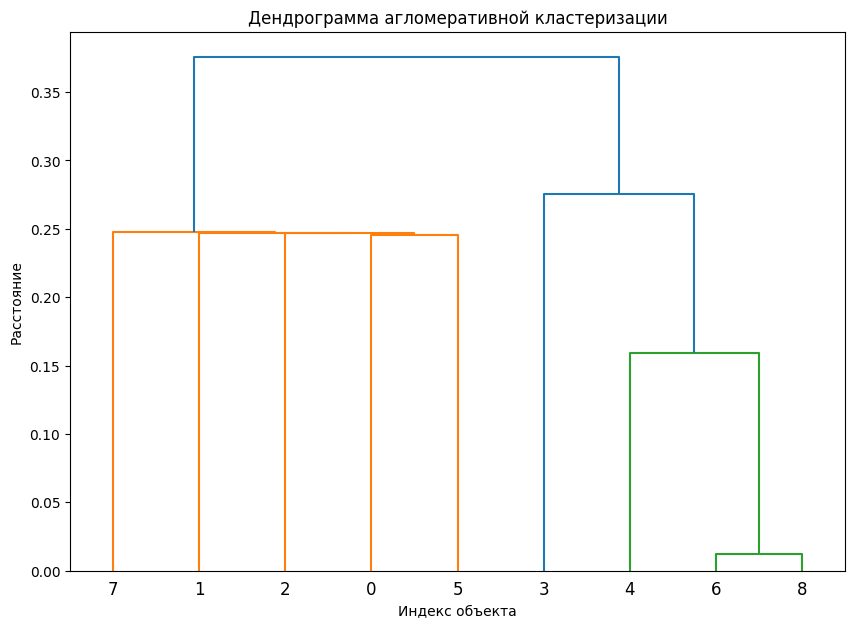

In [250]:
distance_matrix = sch.distance.pdist(dots_tuple)

# Построение иерархической кластеризации
linkage_matrix = sch.linkage(distance_matrix)

# Построение дендрограммы
plt.figure(figsize=(10, 7))
sch.dendrogram(linkage_matrix)
plt.title('Дендрограмма агломеративной кластеризации')
plt.xlabel('Индекс объекта')
plt.ylabel('Расстояние')
plt.show()

In [251]:
#Ансамбль внутренних метрик
def evaluate_clustering(data, labels):
    silhouette_avg = silhouette_score(data, labels)
    def compactness(data, labels):
        cluster_ids = np.unique(labels)
        compactness_values = []
        for cluster_id in cluster_ids:
            cluster_data = data[labels == cluster_id]
            if len(cluster_data) > 1:
                dist_matrix = pdist(cluster_data)
                intra_dist = np.sum(dist_matrix) / len(dist_matrix)
                compactness_values.append(intra_dist)
        return np.mean(compactness_values)
    
    compactness_avg = compactness(data, labels)

    def divisibility(data, labels):
        cluster_ids = np.unique(labels)
        centers = np.array([data[labels == cluster_id].mean(axis=0) for cluster_id in cluster_ids])
        if len(centers) > 1:
            inter_dist_matrix = pdist(centers)
            divisibility_value = np.min(inter_dist_matrix)
            return divisibility_value
        return 0
    
    divisibility_value = divisibility(data, labels)

    scorefunction = compactness_avg/divisibility_value



    return silhouette_avg, compactness_avg, divisibility_value, scorefunction



In [252]:
aggl_labels = np.zeros(len(dots_tuple))
for idx, cluster in enumerate(aggl_cluster.clusters):
    for point in cluster:
        aggl_labels[point] = idx

aggl_metrics = evaluate_clustering(dots_tuple, aggl_labels)

In [253]:
divis_labels = np.zeros(len(dots_tuple))
for idx, cluster in enumerate(divis_cluster.clusters):
    for point in cluster:
        divis_labels[point] = idx

divis_metrics = evaluate_clustering(dots_tuple, divis_labels)

In [254]:
print("Агломеративная кластеризация:")
print(f"Силуэт: {aggl_metrics[0]}")
print(f"Компактность (C): {aggl_metrics[1]}")
print(f"Отделимость (D): {aggl_metrics[2]}")
print(f"Score Function (SF): {aggl_metrics[3]}")

Агломеративная кластеризация:
Силуэт: 0.37465447062340845
Компактность (C): 0.24480054237836166
Отделимость (D): 0.38150899679478445
Score Function (SF): 0.6416638780082061


In [255]:
print("Дивизионная кластеризация:")
print(f"Силуэт: {divis_metrics[0]}")
print(f"Компактность (C): {divis_metrics[1]}")
print(f"Отделимость (D): {divis_metrics[2]}")
print(f"Score Function (SF): {divis_metrics[3]}")

Дивизионная кластеризация:
Силуэт: 0.27977773255426513
Компактность (C): 0.2965083348599755
Отделимость (D): 0.37689145337132507
Score Function (SF): 0.7867207712132607
